# 1. Make Features

In [3]:
# Import libraries
import pandas as pd
import requests
import gdown
import pyarrow
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_parquet('new_series.parquet')

In [3]:
data.head()

,series_id,step,timestamp,anglez,enmo,hour,event,night
0,0,0,2018-11-05 10:00:00-04:00,-30.845301,0.0447,10,0.0,1.0
1,0,1,2018-11-05 10:00:05-04:00,-34.181801,0.0443,10,0.0,1.0
2,0,2,2018-11-05 10:00:10-04:00,-33.877102,0.0483,10,0.0,1.0
3,0,3,2018-11-05 10:00:15-04:00,-34.282101,0.0680,10,0.0,1.0
4,0,4,2018-11-05 10:00:20-04:00,-34.385799,0.0768,10,0.0,1.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14334840 entries, 0 to 14334839
Data columns (total 8 columns):
 #   Column     Dtype                                 
---  ------     -----                                 
 0   series_id  uint8                                 
 1   step       uint32                                
 2   timestamp  datetime64[ns, pytz.FixedOffset(-240)]
 3   anglez     float32                               
 4   enmo       float32                               
 5   hour       int64                                 
 6   event      float64                               
 7   night      float64                               
dtypes: datetime64[ns, pytz.FixedOffset(-240)](1), float32(2), float64(2), int64(1), uint32(1), uint8(1)
memory usage: 615.2 MB


In [3]:
df_events = pd.read_csv('new_events.csv')

In [5]:
df_events.head()

,series_id,night,event,step,timestamp
0,0,1,0,11988,2018-11-06T02:39:00-0400
1,0,1,1,14388,2018-11-06T05:59:00-0400
2,0,2,0,28680,2018-11-07T01:50:00-0400
3,0,2,1,31320,2018-11-07T05:30:00-0400
4,0,3,0,44184,2018-11-07T23:22:00-0400


In [7]:
df_events.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1562 entries, 0 to 1561
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   series_id  1562 non-null   int64 
 1   night      1562 non-null   int64 
 2   event      1562 non-null   int64 
 3   step       1562 non-null   int64 
 4   timestamp  1562 non-null   object
dtypes: int64(4), object(1)
memory usage: 61.1+ KB


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14334840 entries, 0 to 14334839
Data columns (total 8 columns):
 #   Column     Dtype                                 
---  ------     -----                                 
 0   series_id  uint8                                 
 1   step       uint32                                
 2   timestamp  datetime64[ns, pytz.FixedOffset(-240)]
 3   anglez     float32                               
 4   enmo       float32                               
 5   hour       int64                                 
 6   event      float64                               
 7   night      float64                               
dtypes: datetime64[ns, pytz.FixedOffset(-240)](1), float32(2), float64(2), int64(1), uint32(1), uint8(1)
memory usage: 615.2 MB


In [4]:
# Convert the timestamp column of df_events to datetime type
df_events['timestamp'] = pd.to_datetime(df_events['timestamp'])

# check the data type of timestamp column
print(df_events.dtypes)

series_id     int64
night         int64
event         int64
step          int64
timestamp    object
dtype: object


1.1 Add a new feature —— sleep_duration

In [5]:
import pandas as pd

# calculate sleeping time function
def calculate_sleep_time(group):
    sleep_start = group[group['event'] == 0]['timestamp'].min()
    sleep_end = group[group['event'] == 1]['timestamp'].max()
    if pd.notnull(sleep_start) and pd.notnull(sleep_end):
        sleep_duration = (sleep_end - sleep_start).total_seconds() / 3600  # change time unit to hour
    else:
        sleep_duration = 0
    return pd.Series({'sleep_duration': sleep_duration})

# apply function to calculate every series_id's sleep duration
sleep_durations = df_events.groupby(['series_id', 'night']).apply(calculate_sleep_time).reset_index()

print(sleep_durations.head())


   series_id  night  sleep_duration
0          0      1        3.333333
1          0      2        3.666667
2          0      3        6.866667
3          0      4        8.316667
4          0      5        8.500000


In [11]:
sleep_durations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   series_id       781 non-null    int64  
 1   night           781 non-null    int64  
 2   sleep_duration  781 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 18.4 KB


In [6]:
import pandas as pd

# Calculate the sleep duration for each series_id and night
sleep_durations = df_events.groupby(['series_id', 'night']).apply(calculate_sleep_time).reset_index()

# merge sleep_durations with train_data
merged_data = pd.merge(data, sleep_durations, on=['series_id', 'night'], how='left')

print(merged_data.head())

   series_id  step                 timestamp     anglez    enmo  hour  event  \
0          0     0 2018-11-05 10:00:00-04:00 -30.845301  0.0447    10    0.0   
1          0     1 2018-11-05 10:00:05-04:00 -34.181801  0.0443    10    0.0   
2          0     2 2018-11-05 10:00:10-04:00 -33.877102  0.0483    10    0.0   
3          0     3 2018-11-05 10:00:15-04:00 -34.282101  0.0680    10    0.0   
4          0     4 2018-11-05 10:00:20-04:00 -34.385799  0.0768    10    0.0   

   night  sleep_duration  
0    1.0        3.333333  
1    1.0        3.333333  
2    1.0        3.333333  
3    1.0        3.333333  
4    1.0        3.333333  


In [13]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14334840 entries, 0 to 14334839
Data columns (total 9 columns):
 #   Column          Dtype                                 
---  ------          -----                                 
 0   series_id       uint8                                 
 1   step            uint32                                
 2   timestamp       datetime64[ns, pytz.FixedOffset(-240)]
 3   anglez          float32                               
 4   enmo            float32                               
 5   hour            int64                                 
 6   event           float64                               
 7   night           float64                               
 8   sleep_duration  float64                               
dtypes: datetime64[ns, pytz.FixedOffset(-240)](1), float32(2), float64(3), int64(1), uint32(1), uint8(1)
memory usage: 833.9 MB


1.2 make features

In [7]:
def make_features(df):
    periods = 60
    df["event"]=df["event"].fillna("None")
    df["night"]=df["night"].fillna("None")
    df["sleep_duration"]=df["sleep_duration"].fillna(0)
    df["anglez"] = abs(df["anglez"])
    df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill").astype('float16')
    df["enmo_diff"] = df.groupby('series_id')['enmo'].diff(periods=periods).fillna(method="bfill").astype('float16')


    df["anglez_rolling_mean"] = df["anglez"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_rolling_mean"] = df["enmo"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_rolling_max"] = df["anglez"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_rolling_max"] = df["enmo"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_rolling_std"] = df["anglez"].rolling(periods,center=True).std().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_rolling_std"] = df["enmo"].rolling(periods,center=True).std().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_diff_rolling_mean"] = df["anglez_diff"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_diff_rolling_mean"] = df["enmo_diff"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_diff_rolling_max"] = df["anglez_diff"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_diff_rolling_max"] = df["enmo_diff"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    
    # New features, Kurtosis and Skewness
    # Kurtosis: how peaked a distribution is and how much spread it has
    # Skewness: how much a distribution is pushed left or right
    df["anglez_rolling_kurt"] = df["anglez"].rolling(window=periods).kurt().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_rolling_kurt"] = df["enmo"].rolling(window=periods).kurt().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_rolling_skew"] = df["enmo"].rolling(window=periods).skew().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_rolling_skew"] = df["anglez"].rolling(window=periods).skew().fillna(method="bfill").fillna(method="ffill").astype('float16')

    df['timestamp'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))
    df['hour'] = df['timestamp'].dt.hour
    
    return df



Window size will also affect the follow-up, here the choice of period = 60, equivalent to every five minutes statistics.

I also tested period =200 or so, but the result is not good.

When testing period=30, the KMO will be slightly higher, but the running time is long, so it is better to use period=60.

In the future work, maybe we can try to find the best window size using the grid search method.

In [8]:
features = ["hour",
            "sleep_duration",
            "event",
            "night",
            "anglez",
            "anglez_rolling_mean",
            "anglez_rolling_max",
            "anglez_rolling_std",
            "anglez_diff",
            "anglez_diff_rolling_mean",
            "anglez_diff_rolling_max",
            "enmo",
            "enmo_rolling_mean",
            "enmo_rolling_max",
            "enmo_rolling_std",
            "enmo_diff",
            "enmo_diff_rolling_mean",
            "enmo_diff_rolling_max",
            "anglez_rolling_kurt",
            "enmo_rolling_kurt",
            "enmo_rolling_skew",
            "enmo_rolling_skew"
           ]

In [9]:
all_data = make_features(merged_data)

In [10]:
# save memory
import gc
del data
del merged_data
del sleep_durations
del df_events
gc.collect()

39

In [18]:
all_data.head()

,series_id,step,timestamp,anglez,enmo,hour,event,night,sleep_duration,anglez_diff,...,anglez_rolling_std,enmo_rolling_std,anglez_diff_rolling_mean,enmo_diff_rolling_mean,anglez_diff_rolling_max,enmo_diff_rolling_max,anglez_rolling_kurt,enmo_rolling_kurt,enmo_rolling_skew,anglez_rolling_skew
0,0,0,2018-11-05 10:00:00,30.845301,0.0447,10,0.0,1.0,3.333333,-9.125,...,3.712891,0.031433,-9.125,0.017502,-9.125,0.017502,0.08136,4.152344,1.876953,-0.237183
1,0,1,2018-11-05 10:00:05,34.181801,0.0443,10,0.0,1.0,3.333333,-9.125,...,3.712891,0.031433,-9.125,0.017502,-9.125,0.017502,0.08136,4.152344,1.876953,-0.237183
2,0,2,2018-11-05 10:00:10,33.877102,0.0483,10,0.0,1.0,3.333333,-9.125,...,3.712891,0.031433,-9.125,0.017502,-9.125,0.017502,0.08136,4.152344,1.876953,-0.237183
3,0,3,2018-11-05 10:00:15,34.282101,0.0680,10,0.0,1.0,3.333333,-9.125,...,3.712891,0.031433,-9.125,0.017502,-9.125,0.017502,0.08136,4.152344,1.876953,-0.237183
4,0,4,2018-11-05 10:00:20,34.385799,0.0768,10,0.0,1.0,3.333333,-9.125,...,3.712891,0.031433,-9.125,0.017502,-9.125,0.017502,0.08136,4.152344,1.876953,-0.237183


In [19]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14334840 entries, 0 to 14334839
Data columns (total 25 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   series_id                 uint8         
 1   step                      uint32        
 2   timestamp                 datetime64[ns]
 3   anglez                    float32       
 4   enmo                      float32       
 5   hour                      int64         
 6   event                     float64       
 7   night                     float64       
 8   sleep_duration            float64       
 9   anglez_diff               float16       
 10  enmo_diff                 float16       
 11  anglez_rolling_mean       float16       
 12  enmo_rolling_mean         float16       
 13  anglez_rolling_max        float16       
 14  enmo_rolling_max          float16       
 15  anglez_rolling_std        float16       
 16  enmo_rolling_std          float16       
 17  anglez

In [20]:
all_data.describe()

,series_id,step,anglez,enmo,hour,event,night,sleep_duration,anglez_diff,enmo_diff,...,anglez_rolling_std,enmo_rolling_std,anglez_diff_rolling_mean,enmo_diff_rolling_mean,anglez_diff_rolling_max,enmo_diff_rolling_max,anglez_rolling_kurt,enmo_rolling_kurt,enmo_rolling_skew,anglez_rolling_skew
count,1.433484e+07,1.433484e+07,1.433484e+07,1.433484e+07,1.433484e+07,1.433484e+07,1.433484e+07,1.433484e+07,1.433484e+07,1.433484e+07,...,1.433484e+07,1.433484e+07,1.433484e+07,1.433484e+07,1.433484e+07,1.433484e+07,1.433484e+07,1.433484e+07,1.433484e+07,1.433484e+07
mean,1.761231e+01,2.106562e+05,3.215752e+01,4.338994e-02,1.151840e+01,6.740476e-01,1.207422e+01,8.343850e+00,-2.428055e-03,-5.364418e-07,...,NaN,NaN,-2.410889e-03,-5.364418e-07,NaN,NaN,NaN,NaN,NaN,NaN
std,1.048363e+01,1.334162e+05,2.262184e+01,1.127411e-01,6.939381e+00,4.687296e-01,7.131046e+00,1.897588e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,5.102539e-02,0.000000e+00,0.000000e+00,NaN,NaN,0.000000e+00,NaN
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-9.000000e+01,-7.015625e+00,...,0.000000e+00,0.000000e+00,-8.712500e+01,-1.638672e+00,-7.831250e+01,-2.010498e-01,-inf,-inf,-8.703125e+00,-inf
25%,8.000000e+00,9.851700e+04,1.283290e+01,8.000000e-04,5.000000e+00,0.000000e+00,6.000000e+00,7.350000e+00,-9.875000e+00,-1.069641e-02,...,3.044922e+00,3.049850e-03,-5.105469e+00,-7.850647e-03,1.141406e+01,1.519775e-02,-8.574219e-01,1.368164e+00,1.205078e+00,-3.886719e-01
50%,1.800000e+01,2.011495e+05,2.918420e+01,1.550000e-02,1.200000e+01,1.000000e+00,1.100000e+01,8.450000e+00,0.000000e+00,0.000000e+00,...,1.206250e+01,2.001953e-02,0.000000e+00,0.000000e+00,3.768750e+01,8.361816e-02,2.694130e-03,6.027344e+00,2.287109e+00,3.640137e-01
75%,2.600000e+01,3.110662e+05,4.986460e+01,4.060000e-02,1.800000e+01,1.000000e+00,1.700000e+01,9.533333e+00,9.929688e+00,1.059723e-02,...,1.687500e+01,5.465698e-02,5.132812e+00,7.659912e-03,5.384375e+01,2.325439e-01,2.128906e+00,1.834375e+01,4.054688e+00,9.936523e-01
max,3.600000e+01,6.346790e+05,9.000000e+01,7.016100e+00,2.300000e+01,1.000000e+00,3.500000e+01,1.655000e+01,9.000000e+01,6.976562e+00,...,4.381250e+01,2.839844e+00,8.731250e+01,1.631836e+00,9.000000e+01,6.976562e+00,inf,inf,7.804688e+00,inf


# 2. Analyze Features

## 2.1 KMO test

In [12]:
all_data_KMO = all_data.copy()

In [22]:
# chech the missing values for train data
all_data_KMO.isnull().sum()

series_id                   0
step                        0
timestamp                   0
anglez                      0
enmo                        0
hour                        0
event                       0
night                       0
sleep_duration              0
anglez_diff                 0
enmo_diff                   0
anglez_rolling_mean         0
enmo_rolling_mean           0
anglez_rolling_max          0
enmo_rolling_max            0
anglez_rolling_std          0
enmo_rolling_std            0
anglez_diff_rolling_mean    0
enmo_diff_rolling_mean      0
anglez_diff_rolling_max     0
enmo_diff_rolling_max       0
anglez_rolling_kurt         0
enmo_rolling_kurt           0
enmo_rolling_skew           0
anglez_rolling_skew         0
dtype: int64

In [23]:
# chech Nan values for train data
all_data_KMO.isna().sum()

series_id                   0
step                        0
timestamp                   0
anglez                      0
enmo                        0
hour                        0
event                       0
night                       0
sleep_duration              0
anglez_diff                 0
enmo_diff                   0
anglez_rolling_mean         0
enmo_rolling_mean           0
anglez_rolling_max          0
enmo_rolling_max            0
anglez_rolling_std          0
enmo_rolling_std            0
anglez_diff_rolling_mean    0
enmo_diff_rolling_mean      0
anglez_diff_rolling_max     0
enmo_diff_rolling_max       0
anglez_rolling_kurt         0
enmo_rolling_kurt           0
enmo_rolling_skew           0
anglez_rolling_skew         0
dtype: int64

In [24]:
# chech the max values for train data
all_data_KMO.max()

series_id                                    36
step                                     634679
timestamp                   2019-07-05 09:14:55
anglez                                     90.0
enmo                                     7.0161
hour                                         23
event                                       1.0
night                                      35.0
sleep_duration                            16.55
anglez_diff                                90.0
enmo_diff                              6.976562
anglez_rolling_mean                        90.0
enmo_rolling_mean                      1.702148
anglez_rolling_max                         90.0
enmo_rolling_max                       7.015625
anglez_rolling_std                      43.8125
enmo_rolling_std                       2.839844
anglez_diff_rolling_mean                87.3125
enmo_diff_rolling_mean                 1.631836
anglez_diff_rolling_max                    90.0
enmo_diff_rolling_max                  6

anglez_rolling_kurt, enmo_rolling_kurt and anglez_rolling_skew have inf (infinite) values, so we need to remove them.

We find that kurt and skew are followed by high peak and high skew values (this is determined by the data, as different ids at the junction can be very different)

Remove three columns to calculate KMO (keep only enmo_rolling_skew)

In [13]:
all_data_KMO = all_data_KMO.drop(columns=["anglez_rolling_kurt","enmo_rolling_kurt","anglez_rolling_skew"])

In [16]:
all_data_for_regression = all_data_KMO.copy()

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo

# Selecting a subset of numeric data, only use 10% of the data for calculation
sampled_data = all_data_KMO.select_dtypes(include=[np.number]).sample(frac=0.2).copy()  

# Standardize the data
scaler = StandardScaler()
sampled_data_scaled = scaler.fit_transform(sampled_data)

# calculate KMO
kmo_all, kmo_model = calculate_kmo(pd.DataFrame(sampled_data_scaled, columns=sampled_data.columns))

print('KMO Model Score:', kmo_model)


KMO Model Score: 0.6704736930679788


Only 10% of the data was taken for testing because the data set was too large for the full test computer to run.

The KMO test is used to assess the suitability of data for factor analysis. It measures whether the partial correlation between the observed variables is small enough to imply that there are common factors between the variables.KMO values range from 0 to 1.

A KMO Model Score: 0.670 indicates that your data are moderately suitable for factor analysis. Typically, a KMO value above 0.6 means that the data is more suitable for factor analysis.

## 2.2 Bartlett’s test

In [17]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(sampled_data_scaled)
chi_square_value, p_value


(54377447.62166682, 0.0)

The Bartlett test was done with the same data with the three features removed.

High χ² value: a high chi-square value indicates that there is a significant difference between the observed correlation matrix and the null correlation matrix (i.e., the variables are not correlated at all).

Low p-value: a p-value of 0.0 indicates that you can reject the null hypothesis that the variables in the data are indeed correlated with each other and not independently uncorrelated.

These results, combined with the relatively high KMO value (0.670) you mentioned earlier, indicate that your data set is well suited for factor analysis. These test results support your decision to proceed with factor extraction and analysis.

## 2.3.1 PCA

The PCA was done with the same data with the three features removed.

In [18]:
from sklearn.decomposition import PCA

# how many features in the original data
print(f"Features before PCA: {all_data_KMO.shape[1]}")

# Standardize the data
scaler = StandardScaler()
numeric_data_scaled = scaler.fit_transform(all_data_KMO.select_dtypes(include=[np.number]))

# apply PCA
pca = PCA(n_components=0.90)  # Retain 90% of the variance
pca.fit(numeric_data_scaled)
transformed_data = pca.transform(numeric_data_scaled)

transformed_df = pd.DataFrame(transformed_data)

print(f"Features after PCA: {pca.n_components_}")

Features before PCA: 22
Features after PCA: 11


In [19]:
# print 11 features names after PCA
print(f"Features after PCA: {all_data_KMO.columns[pca.components_[0].argsort()][-11:]}")

Features after PCA: Index(['anglez_diff', 'anglez_diff_rolling_mean', 'enmo',
       'enmo_diff_rolling_mean', 'enmo_rolling_max', 'hour', 'anglez',
       'anglez_rolling_mean', 'anglez_diff_rolling_max', 'anglez_rolling_max',
       'anglez_rolling_std'],
      dtype='object')


PCA analysis:

PCA is a technique used to reduce the dimensionality of a dataset while trying to retain as much information as possible from the original data. It accomplishes this by identifying the major components or directions in the data that explain most of the variability in the data.

The dataset initially has 22 features. This may mean that the dataset is complex and may contain redundant or less important information. With PCA, the dataset is simplified to only 11 features, which are a compressed representation of the original 22 features designed to retain the most important information.

PCA think the more important features are:'anglez_diff', 'anglez_diff_rolling_mean', 'enmo',
       'enmo_diff_rolling_mean', 'enmo_rolling_max', 'hour', 'anglez',
       'anglez_rolling_mean', 'anglez_diff_rolling_max', 'anglez_rolling_max',
       'anglez_rolling_std'



## 2.3.2 Factor Analysis

In [20]:
all_data_factor_analysis = all_data.copy()

# delete the timestamp column
all_data_factor_analysis = all_data_factor_analysis.drop(columns = 'timestamp')

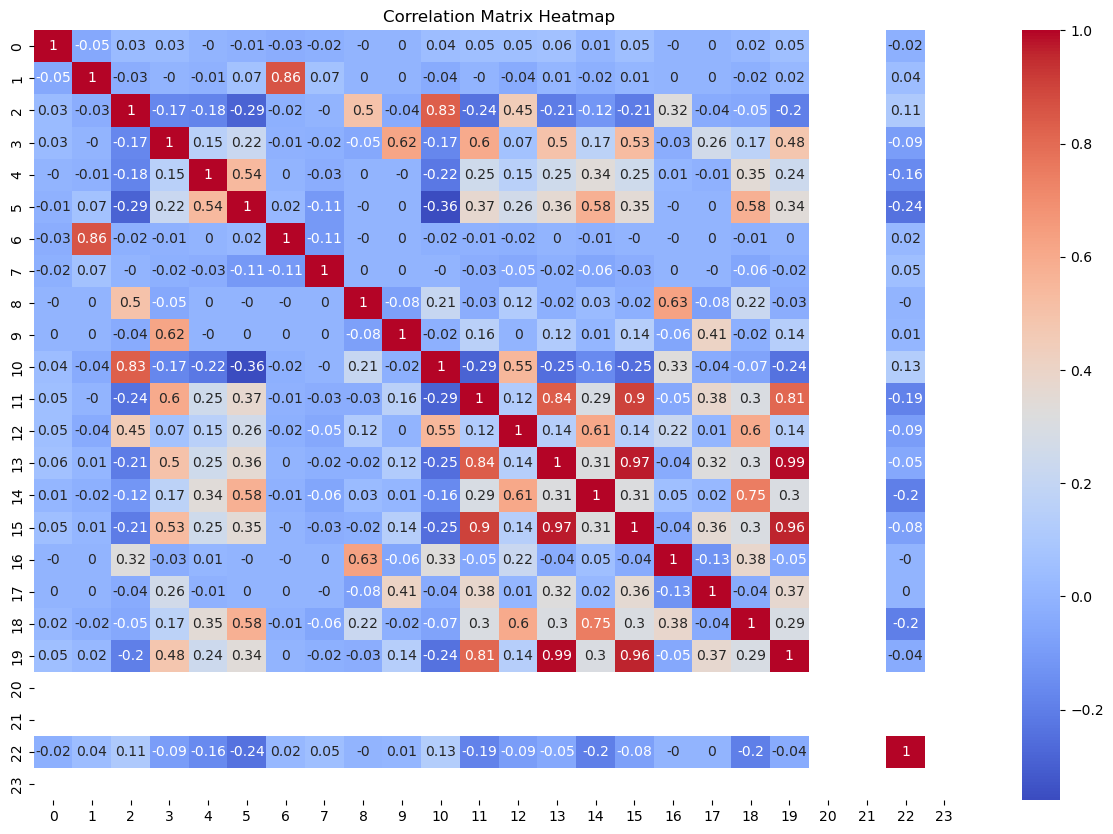

In [21]:
# correlation matrix heatmap
corr = np.corrcoef(all_data_factor_analysis, rowvar=False)
corr = np.round(corr, 2)
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

In this heatmap, we can see that the correlation between the features is not very high, so we can use factor analysis.

The features in the lower right corner are relatively more important to each other, and the features in the upper left corner are relatively less important to each other.

In [22]:
# VIF (Variance Inflation Factor) is used to check multi col-linearity
# Make sure all columns in the features list are present in train_data
features = [f for f in features if f in all_data_KMO.columns]

print('Number of features:', len(features))

# Calculate the VIF using the updated features
X_train = all_data_KMO[features]
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

# calculating VIF for each feature  
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]

print(vif_data)

Number of features: 20
                     feature         VIF
0                       hour    5.271615
1             sleep_duration    9.393438
2                      event    6.911466
3                      night    3.452361
4                     anglez   19.932607
5        anglez_rolling_mean   41.484772
6         anglez_rolling_max   64.363587
7         anglez_rolling_std   11.799796
8                anglez_diff    3.295715
9   anglez_diff_rolling_mean    3.031503
10   anglez_diff_rolling_max   13.876227
11                      enmo    3.595043
12         enmo_rolling_mean   11.938251
13          enmo_rolling_max  121.118181
14          enmo_rolling_std   39.709863
15                 enmo_diff    2.411278
16    enmo_diff_rolling_mean    1.929776
17     enmo_diff_rolling_max   96.584719
18         enmo_rolling_skew         inf
19         enmo_rolling_skew         inf


In a linear regression model, calculating the Variance Inflation Factor (VIF) for each variable is an important step in checking for multicollinearity.The VIF measures the correlation between a variable and other variables. If the VIF of a variable is very high, it means that it is highly correlated with the other variables, and it may be necessary to remove the variable from the model or adjust the variable

In the result of calculating VIF, we can see some features have very high VIF values, like anglez_rolling_mean, anglez_rolling_max, enmo_rolling_max. It seems like these features are highly correlated with other features, so maybe we can remove them.

And we can see the values of enmo_rolling_skew is inf, this may mean that these features are predicted entirely by other variables, or they may be linear combinations of other variables. So we can remove them.

In [34]:
# Perform factor analysis
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo
import matplotlib.pyplot as plt

# Selecting a subset of numeric data (only using 10% of the data for calculation)
sampled_data = all_data_KMO.select_dtypes(include=[np.number]).sample(frac=0.2).copy()  

# Standardize the data
scaler = StandardScaler()
sampled_data_scaled = scaler.fit_transform(sampled_data)

n_factors = sampled_data_scaled.shape[1]
fa = FactorAnalyzer(n_factors, rotation=None)
fa.fit(sampled_data_scaled)

FactorAnalyzer(n_factors=21, rotation=None, rotation_kwargs={})

In [35]:
# Kaiser-Guttman rule
# contains the indices where the eigenvalues of the correlation matrix are greater than 1. 
ev, v = fa.get_eigenvalues()
idx = np.where(ev > 1)[0]

#recommended number of factors to retain based on the Kaiser-Guttman rule.
#length of the array represented by idx
n_factors_kg = idx.size
print(f"Number of factors (Kaiser-Guttman rule): {n_factors_kg}")

Number of factors (Kaiser-Guttman rule): 7


On feature analysis, Kaiser-Guttman rule is used for determine the number of factors. This rule is based on eigenvalue to choose how many factors we should remain.

Eigenvalue essentially measures the importance or contribution of a factor in explaining the variability of the original data. According to the Kaiser-Guttman rule, only those factors with eigenvalues greater than 1 should be retained

Here's why:

Significance of eigenvalues: In factor analysis, eigenvalues indicate the amount of variation explained by a factor. An eigenvalue greater than 1 means that the factor explains more variation than the average of the individual variables (assuming that the total variation of all variables is normalized to 1).

Noise removal: using eigenvalues greater than 1 as a criterion for retaining a factor helps to remove noise. Factor analysis aims to identify underlying structure in the data, and factors with eigenvalues less than 1 do not explain enough variation to cover the average variation of a variable and may represent noise or unimportant information.

Simplify the model: this rule helps the researcher find a balance between creating a concise and explanatory model and retaining enough information. 

By retaining only factors with eigenvalues greater than 1, the complexity of the model can be reduced while still retaining most of the valuable information

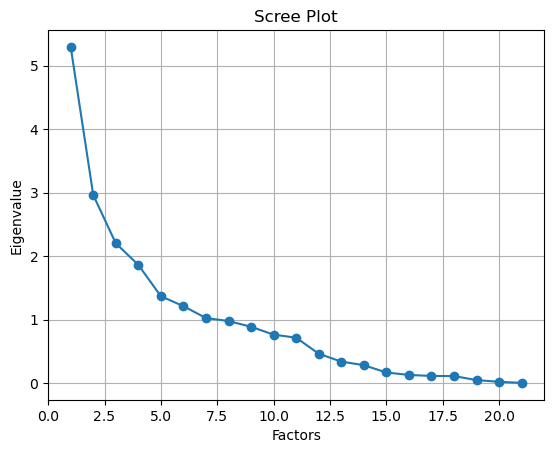

In [36]:
# Scree plot
plt.plot(range(1,n_factors+1), ev, marker='o')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.grid()
plt.show()

In [37]:
# Varimax rotation
fa = FactorAnalyzer(5, rotation='varimax')
fa.fit(sampled_data_scaled)

FactorAnalyzer(n_factors=5, rotation='varimax', rotation_kwargs={})

In [38]:
# Get the factor loadings
loadings = fa.loadings_

# Print the factor loadings
print("Factor loadings:\n", loadings)

Factor loadings:
 [[ 5.51018229e-02  5.82572704e-03  5.04034822e-02 -4.28591872e-02
   2.23613251e-03]
 [ 7.38351790e-03  6.31980750e-03 -3.03404725e-02  9.97286097e-01
   6.00585413e-03]
 [-1.11961619e-01 -2.29980869e-01  7.36069456e-01 -8.52920165e-03
   3.94696011e-01]
 [ 5.91829375e-01  1.25704096e-01 -2.45643030e-02 -8.59078815e-03
  -8.15470799e-02]
 [ 1.22747316e-01  4.73810431e-01 -1.44108380e-01 -7.38014551e-03
   2.33873407e-02]
 [ 1.69043989e-01  7.34220005e-01 -2.03261222e-01  3.76119300e-02
   1.40517889e-02]
 [-3.82574874e-03  1.11229842e-02 -1.00307757e-02  8.59886493e-01
  -2.88532482e-03]
 [-9.21743223e-03 -8.51136191e-02 -1.38721010e-02 -1.29210894e-02
   6.52764632e-03]
 [-4.88775233e-02  5.24919493e-03  1.33423802e-01  6.46600496e-04
   8.24775197e-01]
 [ 3.09862784e-01 -6.90863484e-02  8.00867737e-02  1.00625038e-03
  -1.59905963e-01]
 [-1.36050038e-01 -2.45217717e-01  8.87896501e-01 -1.08568538e-02
   1.85994262e-01]
 [ 8.46186434e-01  2.70456451e-01 -1.34609724e-

In [39]:
#Promax rotation
fa = FactorAnalyzer(n_factors_kg, rotation='promax')
fa.fit(sampled_data_scaled)

FactorAnalyzer(n_factors=7, rotation_kwargs={})

In [40]:
# Get the factor loadings
loadings2 = fa.loadings_

# Print the factor loadings
print("Factor loadings:\n", loadings2)

Factor loadings:
 [[ 0.05960671  0.0483009  -0.03371422  0.01229732 -0.0134661  -0.01210261
  -0.01084701]
 [ 0.10560581  0.03321739  1.01785593  0.03110444 -0.02967307 -0.01350442
  -0.03002006]
 [-0.07534928  0.90411185  0.02779089 -0.1882532   0.00965977  0.28242949
   0.12017136]
 [ 0.30286021 -0.05773503 -0.01489725  0.022797    0.55162391  0.05936408
   0.07803195]
 [ 0.07479519 -0.04156405 -0.02692658 -0.01538678 -0.03005293  0.01713811
   0.55792173]
 [ 0.07673579 -0.10047389  0.01738219  0.08534574 -0.02887501  0.00530916
   0.7874337 ]
 [ 0.07498254  0.04262962  0.87818617  0.03686522 -0.02130149 -0.02136291
  -0.02225181]
 [ 0.00758148 -0.03863906 -0.0117718   0.0026323  -0.00124515  0.01356867
  -0.11531644]
 [ 0.08714293  0.18552231 -0.02336564 -0.11772108 -0.01427024  0.80300521
   0.09783085]
 [-0.25326395  0.04186151 -0.03654537  0.04772646  1.09097283  0.01597524
  -0.01488452]
 [-0.16171681  0.85338229  0.0506471   0.08942855  0.04160478  0.05864526
  -0.13719384]
 [ 

In [41]:
# Perform factor analysis
n_factors = sampled_data_scaled.shape[1]
fa = FactorAnalyzer(5, rotation='varimax')
fa.fit(sampled_data_scaled)

FactorAnalyzer(n_factors=5, rotation='varimax', rotation_kwargs={})

In [42]:
correlation_matrix = np.corrcoef(loadings, rowvar=False)
print (correlation_matrix)

[[ 1.          0.18605155 -0.49992509 -0.21370645 -0.35093928]
 [ 0.18605155  1.         -0.23767931 -0.17286283 -0.07926441]
 [-0.49992509 -0.23767931  1.         -0.16375535  0.28879465]
 [-0.21370645 -0.17286283 -0.16375535  1.         -0.14272406]
 [-0.35093928 -0.07926441  0.28879465 -0.14272406  1.        ]]


In [43]:
correlation_matrix = np.corrcoef(loadings2, rowvar=False)
print (correlation_matrix)

[[ 1.         -0.42270727 -0.0454881  -0.23550034 -0.29342676 -0.12306306
  -0.05670195]
 [-0.42270727  1.         -0.04261197 -0.00944071 -0.0460933   0.09970298
  -0.17348309]
 [-0.0454881  -0.04261197  1.         -0.07084015 -0.18369972 -0.19278831
  -0.15601276]
 [-0.23550034 -0.00944071 -0.07084015  1.         -0.06580641 -0.09965238
   0.14867926]
 [-0.29342676 -0.0460933  -0.18369972 -0.06580641  1.         -0.1034815
  -0.11096703]
 [-0.12306306  0.09970298 -0.19278831 -0.09965238 -0.1034815   1.
  -0.10744017]
 [-0.05670195 -0.17348309 -0.15601276  0.14867926 -0.11096703 -0.10744017
   1.        ]]


In [44]:
# calculate Communalities
communalities = fa.get_communalities()

print("Factor Loadings:\n", loadings)
print("\nCorrelation Matrix:\n", correlation_matrix)
print("\nCommunalities:\n", communalities)

Factor Loadings:
 [[ 5.51018229e-02  5.82572704e-03  5.04034822e-02 -4.28591872e-02
   2.23613251e-03]
 [ 7.38351790e-03  6.31980750e-03 -3.03404725e-02  9.97286097e-01
   6.00585413e-03]
 [-1.11961619e-01 -2.29980869e-01  7.36069456e-01 -8.52920165e-03
   3.94696011e-01]
 [ 5.91829375e-01  1.25704096e-01 -2.45643030e-02 -8.59078815e-03
  -8.15470799e-02]
 [ 1.22747316e-01  4.73810431e-01 -1.44108380e-01 -7.38014551e-03
   2.33873407e-02]
 [ 1.69043989e-01  7.34220005e-01 -2.03261222e-01  3.76119300e-02
   1.40517889e-02]
 [-3.82574874e-03  1.11229842e-02 -1.00307757e-02  8.59886493e-01
  -2.88532482e-03]
 [-9.21743223e-03 -8.51136191e-02 -1.38721010e-02 -1.29210894e-02
   6.52764632e-03]
 [-4.88775233e-02  5.24919493e-03  1.33423802e-01  6.46600496e-04
   8.24775197e-01]
 [ 3.09862784e-01 -6.90863484e-02  8.00867737e-02  1.00625038e-03
  -1.59905963e-01]
 [-1.36050038e-01 -2.45217717e-01  8.87896501e-01 -1.08568538e-02
   1.85994262e-01]
 [ 8.46186434e-01  2.70456451e-01 -1.34609724e-

## 2.3.3 Grey Relational Analysis

In [14]:
all_data_importance = all_data_KMO.copy()

In [15]:
all_data_importance = all_data_importance.drop(columns = 'timestamp')

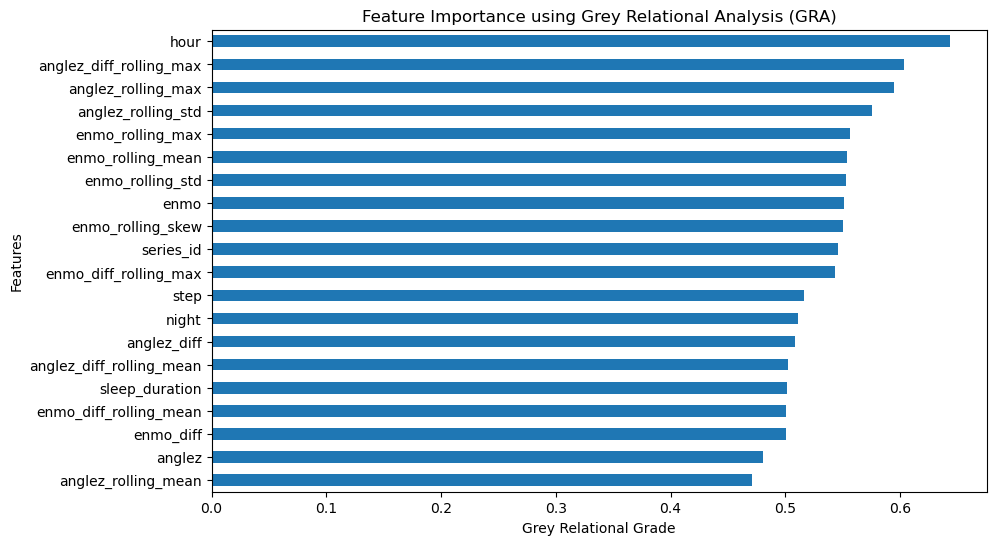

In [16]:
# GRA (Grey Relational Analysis) 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

X = all_data_importance.drop('event', axis=1)
y = all_data_importance['event']

# standardize the data
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

X_normalized = X.apply(normalize_data)
y_normalized = normalize_data(y)

# computed sequence of differences 
def calc_difference_series(norm_data, reference_series):
    return abs(norm_data - reference_series)

difference_series = X_normalized.apply(lambda x: calc_difference_series(x, y_normalized))

# calculate correlation coefficient
def calc_correlation_coefficient(diff_series, rho=0.5):
    min_diff = np.min(diff_series)
    max_diff = np.max(diff_series)
    return (min_diff + rho * max_diff) / (diff_series + rho * max_diff)

correlation_coefficients = difference_series.apply(calc_correlation_coefficient)

# calculate grey relational grade
relation_grades = correlation_coefficients.mean()

plt.figure(figsize=(10, 6))
relation_grades.sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Grey Relational Grade')
plt.ylabel('Features')
plt.title('Feature Importance using Grey Relational Analysis (GRA)')
plt.show()


In [ ]:
# delete non-important features based on GRA, PCA, factor analysis and other methods
# selected features: 'hour'; 'anglez_diff_rolling_max'; 'anglez_rolling_max';  'anglez_rolling_std'; 'enmo_rolling_max';'enmo'; 'seried_id"; 'night';'step';'anglez';'sleep_duration';'timestamp';'event'

In [ ]:
## change float16 to float32 in order to save to parquet file
# for column in all_data_for_regression.select_dtypes('float16').columns:
#     all_data_for_regression[column] = all_data_for_regression[column].astype('float32')

In [ ]:
# # print all_data_for_regression to parquet file
# all_data_for_regression.to_parquet('all_data_for_regression.parquet')